<h1> Predizione dei prezzi delle auto </h1>

<h2> Introduzione</h2>

L’obiettivo del progetto è addestrare e valutare uno o più modelli di regressione per predire il
 prezzo di vendita di automobili usate.
 Il progetto si basa su un dataset contenente circa 40,000 esempi di automobili usate vendute
 nel Regno Unito, fornito tramite il file CSV `car_prices.csv`

 | Colonna        | Descrizione                                     |
|----------------|-------------------------------------------------|
| manufacturer   | Casa produttrice                                |
| model          | Modello                                         |
| year           | Anno di produzione                              |
| transmission   | Cambio automatico/manuale                       |
| mileage        | Miglia percorse                                 |
| fuelType       | Alimentazione (e.g., benzina, diesel)           |
| mpg            | Consumo stimato (miglia per gallone)            |
| engineSize     | Cilindrata                                      |
| price          | Prezzo di vendita (target della predizione)     |

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.cm as cm
from math import nan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error


In [3]:
pip install -q -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras_tuner as kt
from keras_tuner import Hyperband

In [6]:
path ='car_prices.csv'
dataset = pd.read_csv(path)
dataset.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0,17300


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41306 entries, 0 to 41305
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  41306 non-null  object 
 1   model         41306 non-null  object 
 2   year          41306 non-null  int64  
 3   transmission  41306 non-null  object 
 4   mileage       41306 non-null  int64  
 5   fuelType      41306 non-null  object 
 6   mpg           41306 non-null  float64
 7   engineSize    41306 non-null  float64
 8   price         41306 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.8+ MB


<h2> Visualizzazione dati</h2>

<h3> Distribuzione delle variabili numeriche  </h3>

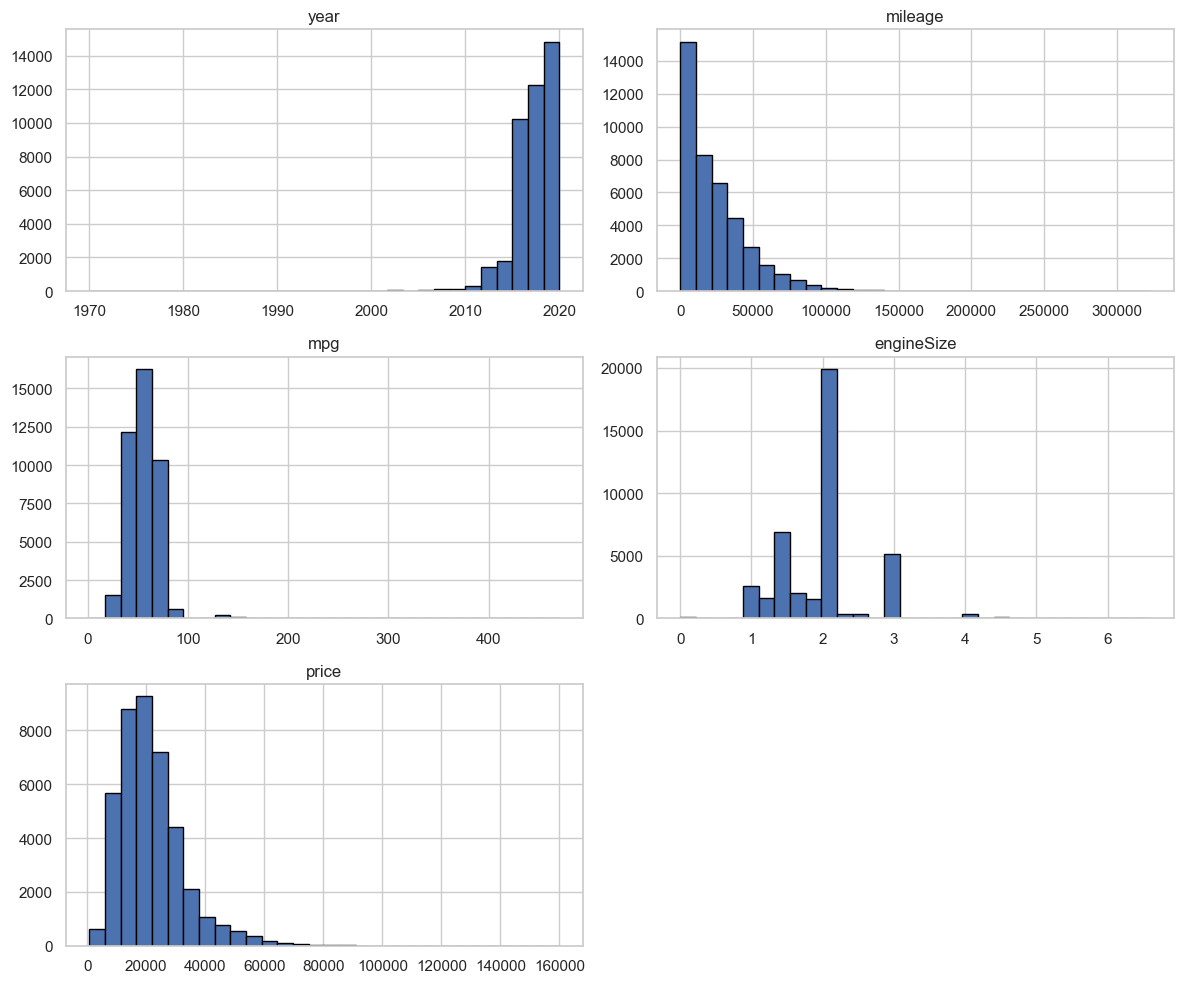

In [20]:
# Uso di Seaborn
sns.set(style="whitegrid")

# Disegna istogrammi per le variabili numeriche
numerical_features = ['year', 'mileage', 'mpg', 'engineSize', 'price']
dataset[numerical_features].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

Osservazione: E' possibile notare come le varie distribuzioni presentino forme asimmetriche.

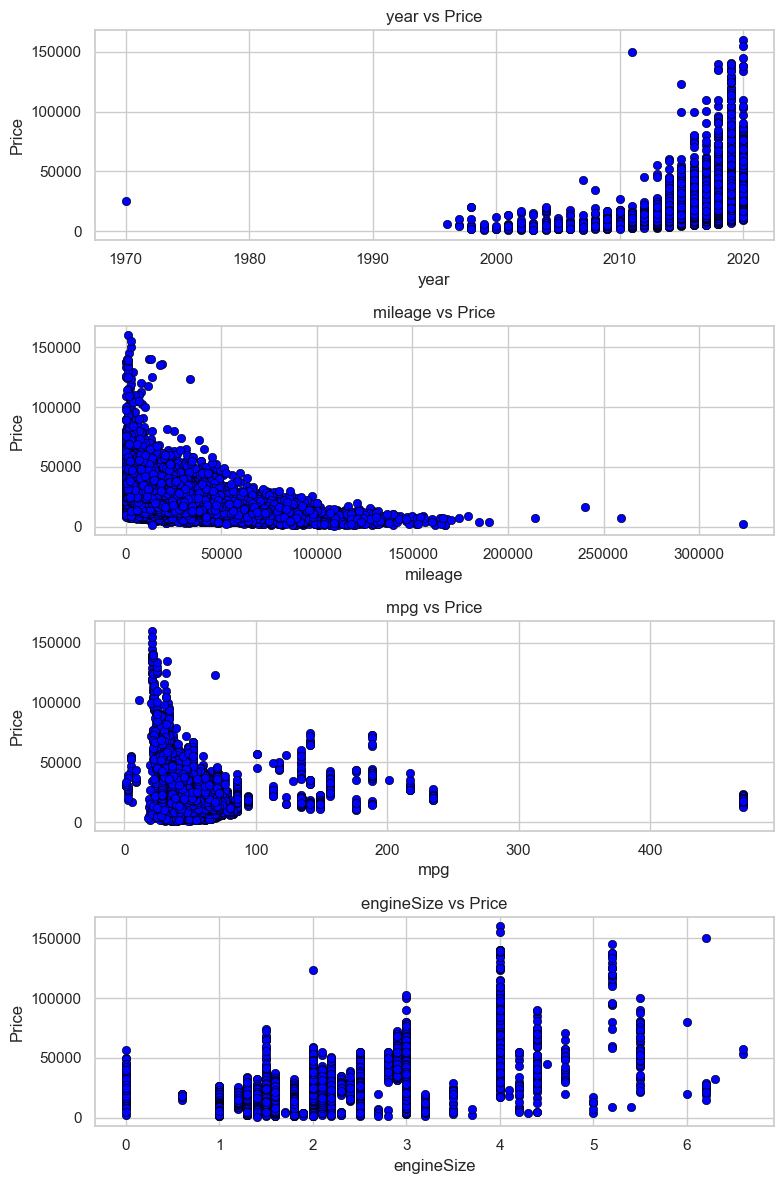

In [50]:
# Elenco delle variabili numeriche per cui fare grafici a dispersione
numerical_features = ['year', 'mileage', 'mpg', 'engineSize']

# Crea una figura con sottoplot per ogni variabile numerica
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(8, 12), sharex=False)

for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=feature, y='price', data=dataset, ax=axes[i], color='blue', edgecolor='black')
    axes[i].set_title(f'{feature} vs Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

<h4> Relazioni tra variabili numeriche </h4>

1. **Relazione Anno e Prezzo**:
   - È possibile notare una dipendenza proporzionale tra l'anno di produzione e il prezzo. In altre parole, le auto più recenti tendono ad avere un prezzo più elevato.

2. **Relazione Chilometraggio e Prezzo**:
   - La relazione tra chilometraggio e prezzo sembra essere inversamente proporzionale. Auto con maggiore chilometraggio tendono ad avere un prezzo inferiore.

3. **Relazione Consumi (mpg) e Prezzo**:
   - I consumi stimati (mpg) non sembrano influenzare significativamente il prezzo dell'auto. La variazione nei consumi non ha una forte correlazione con il prezzo.

4. **Relazione Dimensione del Motore e Prezzo**:
   - La dimensione del motore sembra avere una relazione più marcata con il prezzo rispetto ai consumi. Auto con motori più grandi tendono ad avere un prezzo più elevato.


Questi aspetti possono essere riassunti dalla **Matrice di correlazione**.

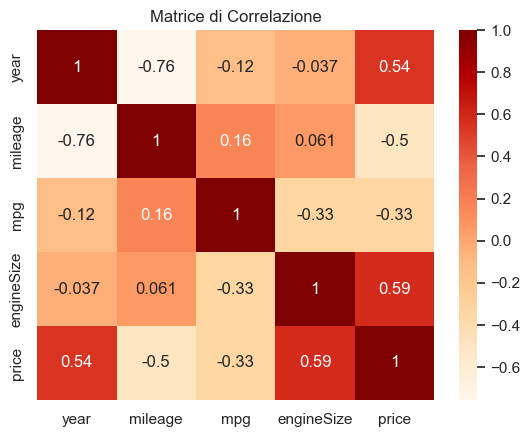

In [34]:
correlation_matrix = dataset.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='OrRd')
plt.title('Matrice di Correlazione')
plt.show()

<h3> Distribuzione delle variabili categoriche </h3>

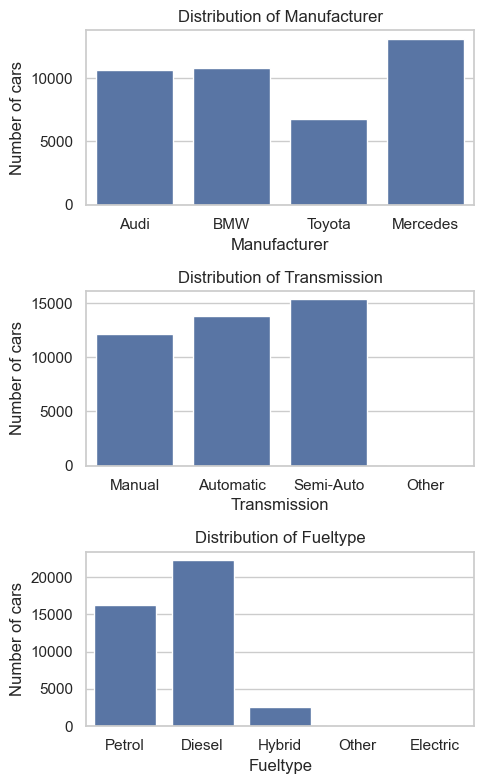

In [63]:
# Elenco delle variabili categoriche da visualizzare
categorical_features = ['manufacturer', 'transmission', 'fuelType']

# Imposta dimensioni dei grafici
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(5, 8), sharex=False)

for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=dataset, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature.capitalize()}')
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Number of cars')

plt.tight_layout()
plt.show()

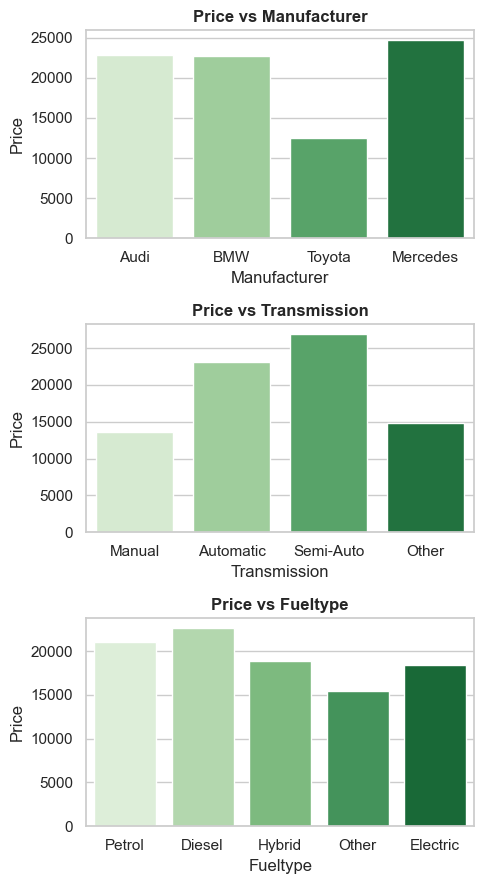

In [64]:
# Crea una figura con sottoplot per ogni variabile categorica
fig, axes = plt.subplots(len(categorical_features), 1, figsize=(5, 3 * len(categorical_features)), sharex=False)

for i, feature in enumerate(categorical_features):
    sns.barplot(data=dataset, x=feature, y='price', palette="Greens", errorbar=None, ax=axes[i], dodge=False, hue=feature, legend=False)
    axes[i].set_title(f'Price vs {feature.capitalize()}', fontweight='bold')  # Titolo in grassetto
    axes[i].set_xlabel(feature.capitalize())
    axes[i].set_ylabel('Price')
    axes[i].tick_params(axis='x')

plt.tight_layout()
plt.show()

<h4> Osservazioni sui Prezzi delle Auto</h4>

- **Prezzo per Fabbricante**:
  Notiamo come Mercedes produca vetture leggermente più costose di Audi e BMW, mentre Toyota si posiziona con prezzi mediamente più bassi.

- **Prezzo per Tipo di Trasmissione e Carburante**:
  Generalmente, troviamo prezzi più alti per auto con cambio semi-automatico e per quelle alimentate a diesel.


<h2> Pulizia dati</h2>

<h3> Controllo di valori mancanti o duplicati </h3>

In [66]:
# **Controllo dei Dati Mancanti**

# Controlla la presenza di dati mancanti per ogni colonna
missing_data = dataset.isnull().sum()
print("Dati Mancanti per Colonna:")
print(missing_data)

# Controlla il totale dei dati mancanti nel dataset
total_missing = missing_data.sum()
print(f"\nTotale Dati Mancanti: {total_missing}")

# **Pulizia dei Dati Mancanti**

# Rimuovi righe con dati mancanti
dataset_cleaned = dataset.dropna()
print(f"\nNumero di Righe Dopo la Rimozione dei Dati Mancanti: {dataset_cleaned.shape[0]}")

Dati Mancanti per Colonna:
manufacturer    0
model           0
year            0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
price           0
dtype: int64

Totale Dati Mancanti: 0

Numero di Righe Dopo la Rimozione dei Dati Mancanti: 41306


In [74]:
# Conta il numero di righe duplicate
num_duplicates = dataset.duplicated().sum()

# Rimuovi righe duplicate
dataset_unique = dataset.drop_duplicates()

# Conta il numero di righe duplicate rimosse
num_removed_duplicates = dataset.shape[0] - dataset_unique.shape[0]

# Stampa il numero di righe duplicate rimosse con il messaggio
print(f"Le righe duplicate rimosse sono: {num_removed_duplicates}")

Le righe duplicate rimosse sono: 563


<h3> Outliers</h3>

Gli outlier sono valori che si discostano significativamente dalla distribuzione normale dei dati. 

Per identificare gli outlier, è comune utilizzare l'intervallo interquartile (IQR), calcolato come segue:
$$\text{IRQ} = \text{Q3} - \text{Q1} $$



Dove **Q1** è il primo quartile (25° percentile) e **Q3** è il terzo quartile (75° percentile)
- Valori inferiori a $\text{Q1} - 1.5 \times \text{IQR}$ sono considerati outlier inferiori.
- Valori superiori a $\text{Q3} + 1.5 \times \text{IQR}$ sono considerati outlier superiori.


In [93]:
# Stampa il numero di righe prima della rimozione degli outliers
print("Numero di righe prima della rimozione degli outliers:", dataset.shape[0])

# Calcola il primo e il terzo quartile per ogni variabile numerica
Q1 = dataset.quantile(0.25, numeric_only=True)
Q3 = dataset.quantile(0.75, numeric_only=True)

# Calcola l'Intervallo Interquartile (IQR) per ogni variabile numerica
IQR = Q3 - Q1

# Allinea i limiti inferiori e superiori con le colonne del DataFrame
Q1_aligned = (Q1 - 1.5 * IQR).reindex(dataset.columns, axis=1)
Q3_aligned = (Q3 + 1.5 * IQR).reindex(dataset.columns, axis=1)

# Identifica le righe che contengono outlier
outliers = dataset[((dataset < Q1_aligned) | (dataset > Q3_aligned)).any(axis=1)]

# Rimuovi gli outliers
dataset_cleaned = dataset[~((dataset < Q1_aligned) | (dataset > Q3_aligned)).any(axis=1)]

# Stampa il numero di righe dopo la rimozione degli outliers
print("Numero di righe dopo la rimozione degli outliers:", dataset_cleaned.shape[0])

# Stampa le righe che sono state rimosse
print("Righe rimosse (outliers):")
print(outliers)


Numero di righe prima della rimozione degli outliers: 32598
Numero di righe dopo la rimozione degli outliers: 32586
Righe rimosse (outliers):
      manufacturer      model  year transmission  mileage fuelType   mpg  \
602           Audi         A3  2015       Manual    68428   Diesel  83.1   
1400          Audi         A3  2017       Manual    68468   Diesel  65.7   
3975          Audi         A4  2016    Semi-Auto    68441   Diesel  72.4   
8618          Audi         Q2  2017    Automatic    68454   Diesel  58.9   
9006          Audi         A3  2015       Manual    68446   Diesel  74.3   
16091          BMW   3 Series  2014    Semi-Auto    68469   Diesel  57.6   
20470          BMW   4 Series  2017    Automatic    68410   Diesel  65.7   
20665          BMW   1 Series  2012       Manual    68397   Diesel  62.8   
32770     Mercedes    C Class  2014    Semi-Auto    68422   Diesel  64.2   
32826     Mercedes    C Class  2014    Semi-Auto    68422   Diesel  64.2   
39043     Mercedes    

<h2> Preparazione modelli di regressione</h2>


<h4> Trasformazione delle variabili categoriche in binarie</h4>

Trasformo le variabili categoriche (come il produttore dell'auto e il tipo di trasmissione) in formato numerico attraverso la tecnica della codifica one-hot. Questo processo crea una colonna separata per ciascuna categoria unica di queste variabili, con valori 0 o 1 che indicano la presenza o l'assenza di quella categoria per ciascuna riga.

In [96]:
# Codifica le variabili categoriche tramite Pandas
dataset_encoded = pd.get_dummies(dataset, columns=['manufacturer', 'model', 'fuelType', 'transmission'])

# Separa le features e il target
X = dataset_encoded.drop('price', axis=1)
y = dataset_encoded['price']

<h4> Generazione di training e testing set</h4>

In [99]:
# Suddivisione dei dati in set di addestramento e test, 20% per il testing, il seed è 123456
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123456)

<h4> Normalizzazione</h4>

La standardizzazione trasforma i dati affinché abbiano una media di 0 e una deviazione standard di 1.


In [98]:
# Creazione dello StandardScaler
scaler = StandardScaler()

# Addestramento dello scaler e trasformazione di X_train
X_train_scaled = scaler.fit_transform(X_train) #fit_transform perchè calcolo le statistiche e normalizzo.

# Trasformazione di X_test
X_test_scaled = scaler.transform(X_test) #solo transform perchè non calcolo le statistiche, uso quelle del training.


<h2> Addestramento e Predizione</h2>

<h3> Regressione Lineare</h3>

### Descrizione della Regressione Lineare

La **regressione lineare** è una tecnica statistica che modella la relazione tra una variabile dipendente e una o più variabili indipendenti attraverso una retta. Essa stima i parametri del modello per minimizzare la differenza tra i valori osservati e quelli previsti dal modello.

- **Predizione**: Utilizza i parametri stimati per fare previsioni sulla variabile dipendente.
- **Calcolo degli Errori**: Misura l'accuratezza del modello con metriche come l'**Errore Assoluto Medio (MAE)**, che calcola la media delle differenze assolute tra i valori osservati e previsti, e l'**Errore Quadratico Medio (MSE)**, che misura la media dei quadrati di queste differenze. Questi errori aiutano a valutare quanto bene il modello si adatta ai dati.

In [ ]:
# Crea il modello di regressione lineare
model = LinearRegression()

# Allena il modello sui dati di addestramento
model.fit(X_train_scaled, y_train)

In [ ]:
# Effettua previsioni sui dati di test
y_pred = model.predict(X_test_scaled)

# Valuta le prestazioni del modello
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
